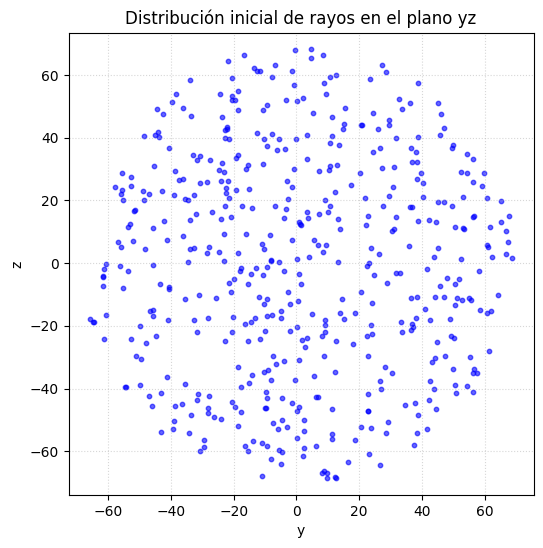

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N = 500       # Número de rayos
R = 70        # Radio del círculo en el plano yz

# 1. Generar posiciones iniciales uniformes dentro del círculo en coordenadas cartesianas (y0, z0)
theta_aleatorio = np.random.uniform(0, 2*np.pi, N)        # Ángulo aleatorio para muestreo
r_aleatorio = R * np.sqrt(np.random.uniform(0, 1, N))     # Radio con distribución uniforme en área

y0 = r_aleatorio  * np.cos(theta_aleatorio)
z0 = r_aleatorio  * np.sin(theta_aleatorio)

# 2. Convertir posiciones cartesianas (y0, z0) a coordenadas cilíndricas (r0, theta0)
r0 = np.sqrt(y0**2 + z0**2)
theta0 = np.arctan2(z0, y0)  # Ángulo en radianes, rango (-pi, pi]

# 3. Visualizar la distribución de posiciones iniciales en el plano yz
plt.figure(figsize=(6,6))
plt.scatter(y0, z0, s=10, color='blue', alpha=0.6)
plt.xlabel('y')
plt.ylabel('z')
plt.title('Distribución inicial de rayos en el plano yz')
plt.axis('equal')  # Escala igual para que el círculo no se distorsione
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()


# Parte 2

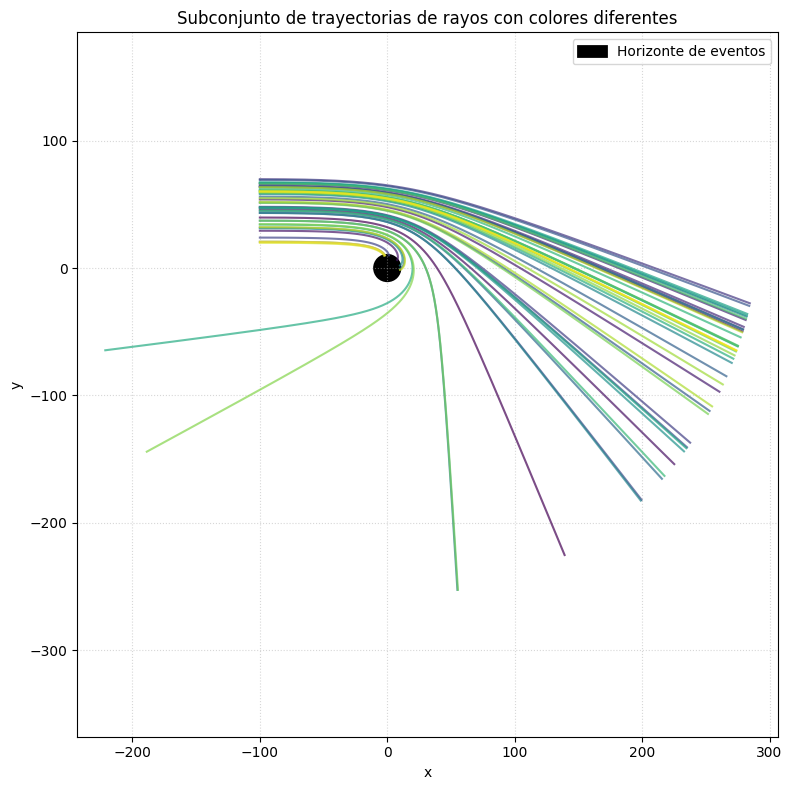

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.cm as cm

# Parámetros
N = 500
R = 70
A = 10
xstart = -100
t_start, t_end = 0, 400
dt = 1
xmax, ymax = 300, 300

# Generar posiciones iniciales uniformes en círculo
theta0 = np.random.uniform(0, 2*np.pi, N)
r0 = R * np.sqrt(np.random.uniform(0, 1, N))

def refindex(x, y):
    eps = 1e-6
    rp0 = np.sqrt(x**2 + y**2)
    n = 1 / (1 - A / (rp0 + eps))
    fac = np.abs(1 - 9*(A / (rp0 + eps))**2 / 8)
    nx = -fac * n**2 * A * x / (rp0 + eps)**3
    ny = -fac * n**2 * A * y / (rp0 + eps)**3
    return [n, nx, ny]

def flow_deriv(t, x_y_z_w):
    x, y, z, w = x_y_z_w
    n, nx, ny = refindex(x, y)
    dxdt = z / n
    dydt = w / n
    dzdt = nx
    dwdt = ny
    return [dxdt, dydt, dzdt, dwdt]

plt.figure(figsize=(8,8))

# Seleccionar un subconjunto aleatorio para graficar
sub_indices = np.random.choice(N, size=50, replace=False)

# Crear un colormap con tantos colores como rayos a graficar
colors = cm.viridis(np.linspace(0, 1, len(sub_indices)))

for idx, i in enumerate(sub_indices):
    x0 = xstart
    y0 = r0[i]
    n0, nx0, ny0 = refindex(x0, y0)
    state0 = [x0, y0, n0, 0]

    t_eval = np.arange(t_start, t_end + dt, dt)
    sol = solve_ivp(flow_deriv, (t_start, t_end), state0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

    x_traj = sol.y[0]
    y_traj = sol.y[1]

    # Verificar intersección con horizonte y límites máximos
    r_raiz = x_traj**2 + y_traj**2
    inside_horizon = np.where(r_raiz < A**2)[0]
    outside_lim = np.where((np.abs(x_traj) > xmax) | (np.abs(y_traj) > ymax))[0]

    trunc_indices = []
    if inside_horizon.size > 0:
        trunc_indices.append(inside_horizon[0])
    if outside_lim.size > 0:
        trunc_indices.append(outside_lim[0])

    if trunc_indices:
        idx_trunc = min(trunc_indices)
        x_traj = x_traj[:idx_trunc+1]
        y_traj = y_traj[:idx_trunc+1]
        plt.plot(x_traj[-1], y_traj[-1], 'ro', markersize=3)  # Punto de truncamiento

    # Graficar trayectoria con color único asignado
    plt.plot(x_traj, y_traj, color=colors[idx], alpha=0.7)

# Dibujar horizonte de eventos
circle = plt.Circle((0, 0), A, color='black', fill=True, linewidth=2, label='Horizonte de eventos')
plt.gca().add_patch(circle)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Subconjunto de trayectorias de rayos con colores diferentes')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Parte 3

Espaciamiento promedio entre puntos: 1.2533


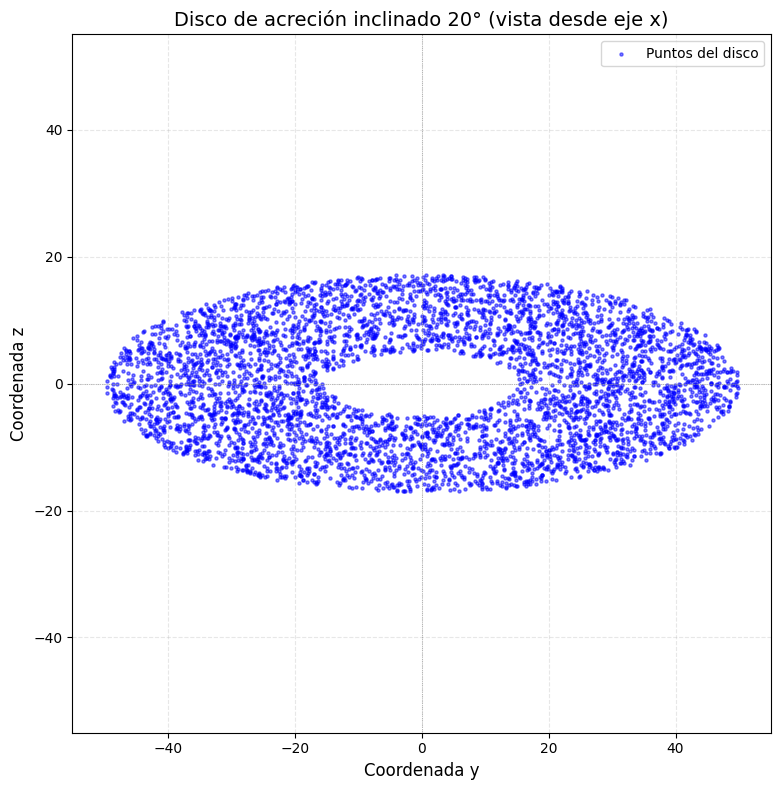

In [ ]:
from scipy.spatial.transform import Rotation as R

# Parámetros del disco
N_d = 5000  # Número de puntos
R_in = 15   # Radio interno
R_out = 50  # Radio externo
i_deg = 20  # Ángulo de inclinación en grados

# 1. Generar puntos uniformemente distribuidos en un anillo con distribución uniforme en área
def generar_puntos_disco(N, R_min, R_max):
    theta = np.random.uniform(0, 2*np.pi, N)
    U = np.random.uniform(0, 1, N)  # variable uniforme para distribución en área
    r = np.sqrt(U * (R_max**2 - R_min**2) + R_min**2)  # distribución uniforme en área
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

# Generar los puntos del disco
puntos_disco = generar_puntos_disco(N_d, R_in, R_out)

# 2. Calcular espaciamiento promedio
d_ave = np.sqrt(np.pi * R_out**2 / N_d)
print(f"Espaciamiento promedio entre puntos: {d_ave:.4f}")

# 3. Inclinar el disco 20° alrededor del eje y
def inclinar_disco(puntos, inclinacion_deg):
    rotacion = R.from_euler('y', inclinacion_deg, degrees=True)
    return rotacion.apply(puntos)

# Aplicar inclinación
inclinar_disco = inclinar_disco(puntos_disco, i_deg)

# 4. Visualización del disco inclinado (proyección yz)
plt.figure(figsize=(10, 8))
plt.scatter(inclinar_disco[:, 1], inclinar_disco[:, 2],
            s=5, alpha=0.5, color='blue', label='Puntos del disco')
plt.axhline(0, color='gray', linestyle=':', lw=0.5)
plt.axvline(0, color='gray', linestyle=':', lw=0.5)
plt.title(f'Disco de acreción inclinado {i_deg}° (vista desde eje x)', fontsize=14)
plt.xlabel('Coordenada y', fontsize=12)
plt.ylabel('Coordenada z', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
max_range = R_out * 1.1
plt.xlim(-max_range, max_range)
plt.ylim(-max_range, max_range)
plt.legend()
plt.tight_layout()
plt.show()


# Parte 4

# Silueta agujero negro

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.spatial import cKDTree
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.style as mplstyle

Espaciamiento promedio entre puntos del disco: 1.2533


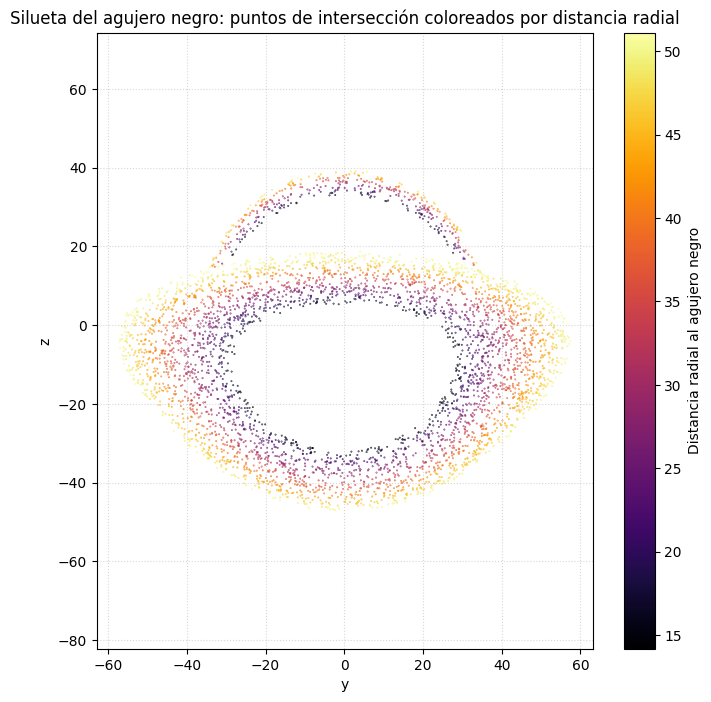

In [ ]:
# Activar estilo rápido para mejor rendimiento
mplstyle.use('fast')

# Parámetros
N = 15000          # Número de rayos (mayor a 10,000)
radio_rayos = 70
radio_agujero = 10
posicion_inicial_x = -100
tiempo_inicio, tiempo_fin = 0, 400
paso_tiempo = 1
limite_x, limite_y = 300, 300

N_puntos_disco = 5000
radio_interno = 15
radio_externo = 50
angulo_inclinacion = 20  # grados

espaciamiento_promedio = np.sqrt(np.pi * radio_externo**2 / N_puntos_disco)
print(f"Espaciamiento promedio entre puntos del disco: {espaciamiento_promedio:.4f}")

# Generar posiciones iniciales
theta0 = np.random.uniform(0, 2*np.pi, N)
r0 = radio_rayos * np.sqrt(np.random.uniform(0, 1, N))

def indice_refraccion(x, y):
    eps = 1e-6
    rp0 = np.sqrt(x**2 + y**2)
    n = 1 / (1 - radio_agujero / (rp0 + eps))
    fac = np.abs(1 - 9*(radio_agujero / (rp0 + eps))**2 / 8)
    nx = -fac * n**2 * radio_agujero * x / (rp0 + eps)**3
    ny = -fac * n**2 * radio_agujero * y / (rp0 + eps)**3
    return [n, nx, ny]

def derivadas_flujo(t, estado):
    x, y, z, w = estado
    n, nx, ny = indice_refraccion(x, y)
    dxdt = z / n
    dydt = w / n
    dzdt = nx
    dwdt = ny
    return [dxdt, dydt, dzdt, dwdt]

def matriz_rotacion_x(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]])

def rotar_rayo(rayo_xy, theta):
    M = rayo_xy.shape[1]
    puntos_3d = np.vstack((rayo_xy, np.zeros(M)))
    R_x = matriz_rotacion_x(theta)
    return R_x @ puntos_3d

def generar_puntos_disco(N, R_min, R_max):
    theta = np.random.uniform(0, 2*np.pi, N)
    U = np.random.uniform(0, 1, N)
    r = np.sqrt(U * (R_max**2 - R_min**2) + R_min**2)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

def inclinar_disco(puntos, angulo):
    rotacion = R.from_euler('y', angulo, degrees=True)
    return rotacion.apply(puntos)

puntos_disco = generar_puntos_disco(N_puntos_disco, radio_interno, radio_externo)
disco_inclinado = inclinar_disco(puntos_disco, angulo_inclinacion)
arbol_kd_disco = cKDTree(disco_inclinado)

intersecciones = np.zeros(N, dtype=bool)
distancias_radiales = np.full(N, -999.0)

t_eval = np.arange(tiempo_inicio, tiempo_fin + paso_tiempo, paso_tiempo)
tamano_bloque = 500

for inicio in range(0, N, tamano_bloque):
    fin = min(inicio + tamano_bloque, N)
    for i in range(inicio, fin):
        n0, _, _ = indice_refraccion(posicion_inicial_x, r0[i])  # Solo n0 para estado inicial
        estado_inicial = [posicion_inicial_x, r0[i], n0, 0]

        solucion = solve_ivp(derivadas_flujo, (tiempo_inicio, tiempo_fin), estado_inicial,
                            t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

        x_trayectoria = solucion.y[0]
        y_trayectoria = solucion.y[1]

        radios_cuadrado = x_trayectoria**2 + y_trayectoria**2
        idx_horizonte = np.where(radios_cuadrado < radio_agujero**2)[0]
        idx_limites = np.where((np.abs(x_trayectoria) > limite_x) | (np.abs(y_trayectoria) > limite_y))[0]
        indices_truncar = []
        if idx_horizonte.size > 0:
            indices_truncar.append(idx_horizonte[0])
        if idx_limites.size > 0:
            indices_truncar.append(idx_limites[0])
        if indices_truncar:
            idx_trunc = min(indices_truncar)
            x_trayectoria = x_trayectoria[:idx_trunc+1]
            y_trayectoria = y_trayectoria[:idx_trunc+1]

        theta_rotacion = theta0[i]
        rayo_xy = np.vstack((x_trayectoria, y_trayectoria))
        trayectoria_3d = rotar_rayo(rayo_xy, theta_rotacion)

        distancias, _ = arbol_kd_disco.query(trayectoria_3d.T, distance_upper_bound=espaciamiento_promedio)
        if np.any(distancias < espaciamiento_promedio):
            intersecciones[i] = True
            idx_inter = np.where(distancias < espaciamiento_promedio)[0][0]
            punto_inter = trayectoria_3d[:, idx_inter]
            distancias_radiales[i] = np.linalg.norm(punto_inter)

# Graficar puntos de intersección coloreados por distancia radial
plt.figure(figsize=(8,8))
indices_intersectados = np.where(intersecciones)[0]
if indices_intersectados.size > 0:
    y_iniciales = r0[indices_intersectados] * np.cos(theta0[indices_intersectados])
    z_iniciales = r0[indices_intersectados] * np.sin(theta0[indices_intersectados])
    distancias_interseccion = distancias_radiales[indices_intersectados]

    scatter = plt.scatter(y_iniciales, z_iniciales, c=distancias_interseccion, s=0.5, cmap='inferno', marker='.')
    plt.colorbar(scatter, label='Distancia radial al agujero negro')
else:
    print("No hay intersecciones para graficar.")

plt.xlabel('y')
plt.ylabel('z')
plt.title('Silueta del agujero negro: puntos de intersección coloreados por distancia radial')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()



# Desarrollos por items para la imagen fnal del agujero negro

Espaciamiento promedio entre puntos del disco: 1.2533


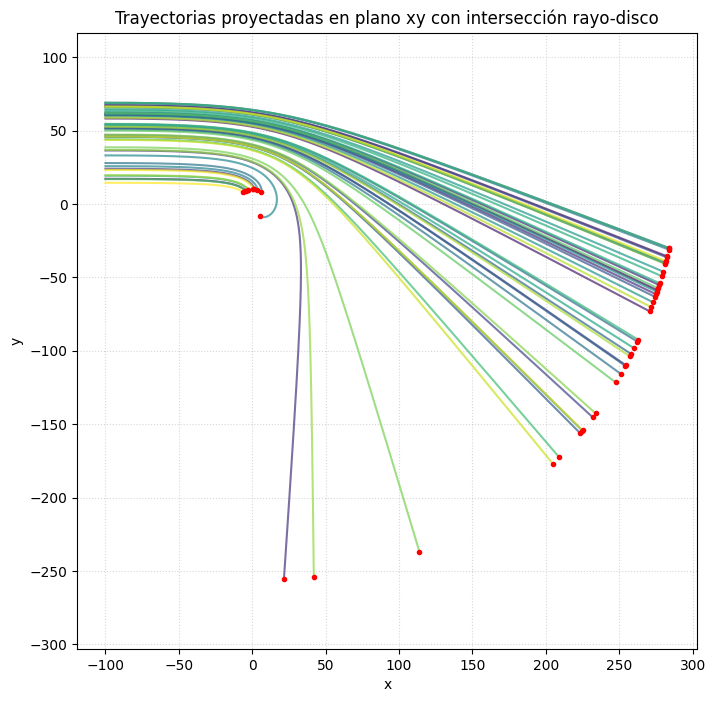

Rayo 0: No interseca el disco
Rayo 1: No interseca el disco
Rayo 2: No interseca el disco
Rayo 3: No interseca el disco
Rayo 4: No interseca el disco
Rayo 5: No interseca el disco
Rayo 6: No interseca el disco
Rayo 7: Interseca el disco
Rayo 8: No interseca el disco
Rayo 9: No interseca el disco
Rayo 10: No interseca el disco
Rayo 11: No interseca el disco
Rayo 12: No interseca el disco
Rayo 13: No interseca el disco
Rayo 14: Interseca el disco
Rayo 15: No interseca el disco
Rayo 16: Interseca el disco
Rayo 17: No interseca el disco
Rayo 18: Interseca el disco
Rayo 19: No interseca el disco
Rayo 20: No interseca el disco
Rayo 21: Interseca el disco
Rayo 22: No interseca el disco
Rayo 23: Interseca el disco
Rayo 24: No interseca el disco
Rayo 25: No interseca el disco
Rayo 26: No interseca el disco
Rayo 27: No interseca el disco
Rayo 28: No interseca el disco
Rayo 29: No interseca el disco
Rayo 30: No interseca el disco
Rayo 31: No interseca el disco
Rayo 32: Interseca el disco
Rayo 33:

In [ ]:
# Parámetros generales
N = 500          # Número de rayos
R_ray = 70       # Cambié nombre para evitar conflicto con Rotation
A = 10           # Radio gravitacional (horizonte de eventos)
xstart = -100    # Posición inicial en x para integración
t_start, t_end = 0, 400
dt = 1
xmax, ymax = 300, 300  # Límites máximos para truncar trayectorias

# Parámetros del disco
N_d = 5000        # Número de puntos en el disco
R_in = 15         # Radio interno
R_out = 50        # Radio externo
i_deg = 20        # Ángulo de inclinación en grados

# Estimación del espaciamiento promedio d_ave
d_ave = np.sqrt(np.pi * R_out**2 / N_d)
print(f"Espaciamiento promedio entre puntos del disco: {d_ave:.4f}")

# -------------------
# Parte 1: Generar posiciones iniciales de rayos en círculo (plano yz)
theta0 = np.random.uniform(0, 2*np.pi, N)
r0 = R_ray * np.sqrt(np.random.uniform(0, 1, N))  # Distribución uniforme en área

# -------------------
# Parte 2: Integración de rayos en el plano xy

def refindex(x, y):
    eps = 1e-6
    rp0 = np.sqrt(x**2 + y**2)
    n = 1 / (1 - A / (rp0 + eps))
    fac = np.abs(1 - 9*(A / (rp0 + eps))**2 / 8)
    nx = -fac * n**2 * A * x / (rp0 + eps)**3
    ny = -fac * n**2 * A * y / (rp0 + eps)**3
    return [n, nx, ny]

def flow_deriv(t, x_y_z_w):
    x, y, z, w = x_y_z_w
    n, nx, ny = refindex(x, y)
    dxdt = z / n
    dydt = w / n
    dzdt = nx
    dwdt = ny
    return [dxdt, dydt, dzdt, dwdt]

def matriz_rotacion_x(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])

def rotar_rayo(rayo_xy, theta):
    M = rayo_xy.shape[1]
    puntos_3d = np.vstack((rayo_xy, np.zeros(M)))  # z=0 plano xy
    R_x = matriz_rotacion_x(theta)
    return R_x @ puntos_3d

# -------------------
# Parte 3: Generar disco inclinado

def generar_puntos_disco(N, R_min, R_max):
    theta = np.random.uniform(0, 2*np.pi, N)
    U = np.random.uniform(0, 1, N)
    r = np.sqrt(U * (R_max**2 - R_min**2) + R_min**2)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

def disco_inclinado(puntos, inclinacion_deg):
    rotacion = R.from_euler('y', inclinacion_deg, degrees=True)
    return rotacion.apply(puntos)

puntos_disco = generar_puntos_disco(N_d, R_in, R_out)
disco_inclinado = disco_inclinado(puntos_disco, i_deg)

# -------------------
# Parte 4: Integrar rayos, rotar y verificar intersección con disco

sub_indices = np.random.choice(N, size=50, replace=False)
colors = cm.viridis(np.linspace(0, 1, len(sub_indices)))

plt.figure(figsize=(8,8))

intersecciones = []

# Crear KDTree para disco para acelerar búsqueda
tree_disco = cKDTree(disco_inclinado)

for idx, i in enumerate(sub_indices):
    x0 = xstart
    y0_r = r0[i]
    n0, nx0, ny0 = refindex(x0, y0_r)
    state0 = [x0, y0_r, n0, 0]

    t_eval = np.arange(t_start, t_end + dt, dt)
    sol = solve_ivp(flow_deriv, (t_start, t_end), state0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

    x_traj = sol.y[0]
    y_traj = sol.y[1]

    # Truncar trayectorias que entran al agujero negro o salen de límites
    r_raiz = x_traj**2 + y_traj**2
    idx_horizon = np.where(r_raiz < A**2)[0]
    idx_bounds = np.where((np.abs(x_traj) > xmax) | (np.abs(y_traj) > ymax))[0]
    trunc_indices = []
    if idx_horizon.size > 0:
        trunc_indices.append(idx_horizon[0])
    if idx_bounds.size > 0:
        trunc_indices.append(idx_bounds[0])
    if trunc_indices:
        idx_trunc = min(trunc_indices)
        x_traj = x_traj[:idx_trunc+1]
        y_traj = y_traj[:idx_trunc+1]

    # Rotar trayectoria al ángulo original theta0[i]
    theta_rot = theta0[i]
    rayo_xy = np.vstack((x_traj, y_traj))
    trayectoria_3d = rotar_rayo(rayo_xy, theta_rot)

    # Verificar intersección con disco usando KDTree
    distancias, _ = tree_disco.query(trayectoria_3d.T, distance_upper_bound=d_ave)
    intersecta = np.any(distancias < d_ave)
    intersecciones.append(intersecta)

    # Graficar trayectoria proyectada en xy
    plt.plot(x_traj, y_traj, color=colors[idx], alpha=0.7)
    plt.plot(x_traj[-1], y_traj[-1], 'ro', markersize=3)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trayectorias proyectadas en plano xy con intersección rayo-disco')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# Mostrar resultados
for idx, inter in enumerate(intersecciones):
    print(f"Rayo {idx}: {'Interseca el disco' if inter else 'No interseca el disco'}")



Espaciamiento promedio entre puntos del disco: 1.2533


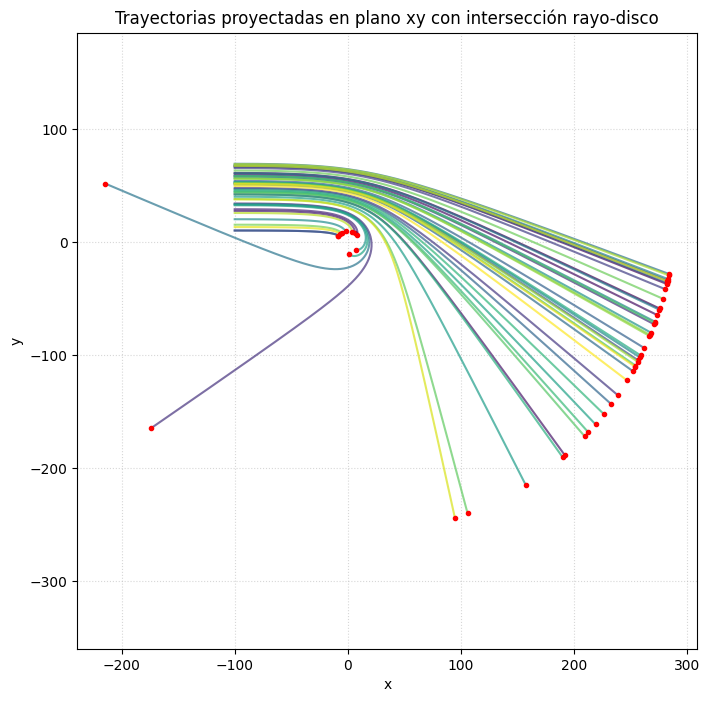

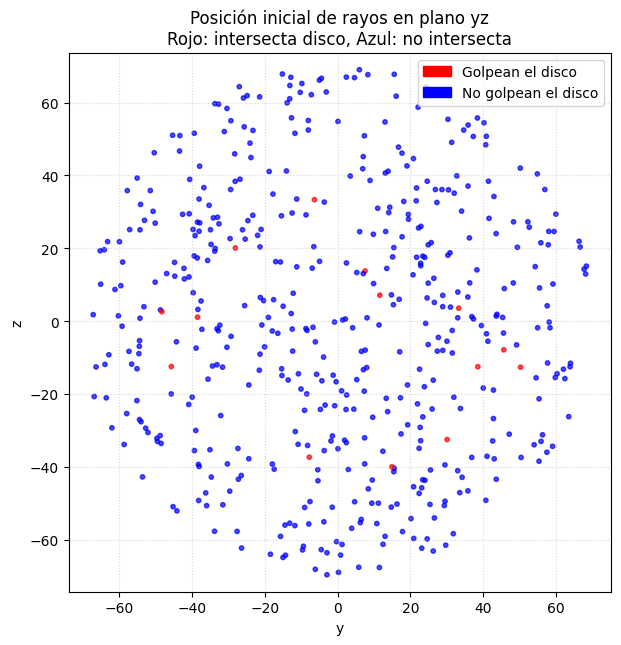

Rayo 0: No interseca el disco (distancia registrada = -999)
Rayo 1: No interseca el disco (distancia registrada = -999)
Rayo 2: No interseca el disco (distancia registrada = -999)
Rayo 3: Interseca el disco a distancia radial 39.0388
Rayo 4: No interseca el disco (distancia registrada = -999)
Rayo 5: No interseca el disco (distancia registrada = -999)
Rayo 6: No interseca el disco (distancia registrada = -999)
Rayo 7: Interseca el disco a distancia radial 22.7447
Rayo 8: Interseca el disco a distancia radial 44.6365
Rayo 9: No interseca el disco (distancia registrada = -999)
Rayo 10: No interseca el disco (distancia registrada = -999)
Rayo 11: No interseca el disco (distancia registrada = -999)
Rayo 12: No interseca el disco (distancia registrada = -999)
Rayo 13: No interseca el disco (distancia registrada = -999)
Rayo 14: No interseca el disco (distancia registrada = -999)
Rayo 15: No interseca el disco (distancia registrada = -999)
Rayo 16: Interseca el disco a distancia radial 39.57

In [ ]:
# Parámetros generales
N = 500          # Número de rayos
R_ray = 70       # Radio para distribución inicial de rayos en yz (renombrado para evitar conflicto)
A = 10           # Radio gravitacional (horizonte de eventos)
xstart = -100    # Posición inicial en x para integración
t_start, t_end = 0, 400
dt = 1
xmax, ymax = 300, 300  # Límites máximos para truncar trayectorias

# Parámetros del disco
N_d = 5000        # Número de puntos en el disco
R_in = 15         # Radio interno
R_out = 50        # Radio externo
i_deg = 20        # Ángulo de inclinación en grados

# Estimación del espaciamiento promedio d_ave
d_ave = np.sqrt(np.pi * R_out**2 / N_d)
print(f"Espaciamiento promedio entre puntos del disco: {d_ave:.4f}")

# Parte 1: Generar posiciones iniciales de rayos en círculo (plano yz)
theta0 = np.random.uniform(0, 2*np.pi, N)
r0 = R_ray * np.sqrt(np.random.uniform(0, 1, N))  # Distribución uniforme en área

# Parte 2: Integración de rayos en el plano xy
def refindex(x, y):
    eps = 1e-6
    rp0 = np.sqrt(x**2 + y**2)
    n = 1 / (1 - A / (rp0 + eps))
    fac = np.abs(1 - 9*(A / (rp0 + eps))**2 / 8)
    nx = -fac * n**2 * A * x / (rp0 + eps)**3
    ny = -fac * n**2 * A * y / (rp0 + eps)**3
    return [n, nx, ny]

def flow_deriv(t, x_y_z_w):
    x, y, z, w = x_y_z_w
    n, nx, ny = refindex(x, y)
    dxdt = z / n
    dydt = w / n
    dzdt = nx
    dwdt = ny
    return [dxdt, dydt, dzdt, dwdt]

def matriz_rotacion_x(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])

def rotar_rayo(rayo_xy, theta):
    M = rayo_xy.shape[1]
    puntos_3d = np.vstack((rayo_xy, np.zeros(M)))  # z=0 plano xy
    R_x = matriz_rotacion_x(theta)
    return R_x @ puntos_3d

# Parte 3: Generar disco inclinado
def generate_disk_points(N, R_min, R_max):
    theta = np.random.uniform(0, 2*np.pi, N)
    U = np.random.uniform(0, 1, N)
    r = np.sqrt(U * (R_max**2 - R_min**2) + R_min**2)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)
    return np.column_stack((x, y, z))

def incline_disk(points, inclination_deg):
    rotation = R.from_euler('y', inclination_deg, degrees=True)
    return rotation.apply(points)

disk_points = generate_disk_points(N_d, R_in, R_out)
inclined_disk = incline_disk(disk_points, i_deg)

# Parte 4: Integrar rayos, rotar y verificar intersección con disco
subset_indices = np.random.choice(N, size=50, replace=False)
colors = cm.viridis(np.linspace(0, 1, len(subset_indices)))

intersecciones = []
distancias_radiales = []

tree_disco = cKDTree(inclined_disk)

plt.figure(figsize=(8,8))

for idx, i in enumerate(subset_indices):
    x0 = xstart
    y0_r = r0[i]
    n0, nx0, ny0 = refindex(x0, y0_r)
    state0 = [x0, y0_r, n0, 0]

    t_eval = np.arange(t_start, t_end + dt, dt)
    sol = solve_ivp(flow_deriv, (t_start, t_end), state0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

    x_traj = sol.y[0]
    y_traj = sol.y[1]

    # Truncar trayectorias que entran al agujero negro o salen de límites
    r_squared = x_traj**2 + y_traj**2
    idx_horizon = np.where(r_squared < A**2)[0]
    idx_bounds = np.where((np.abs(x_traj) > xmax) | (np.abs(y_traj) > ymax))[0]
    trunc_indices = []
    if idx_horizon.size > 0:
        trunc_indices.append(idx_horizon[0])
    if idx_bounds.size > 0:
        trunc_indices.append(idx_bounds[0])
    if trunc_indices:
        idx_trunc = min(trunc_indices)
        x_traj = x_traj[:idx_trunc+1]
        y_traj = y_traj[:idx_trunc+1]

    # Rotar trayectoria al ángulo original theta0[i]
    theta_rot = theta0[i]
    rayo_xy = np.vstack((x_traj, y_traj))
    trayectoria_3d = rotar_rayo(rayo_xy, theta_rot)  # shape (3, M)

    # Verificar intersección con disco usando KDTree
    distancias, _ = tree_disco.query(trayectoria_3d.T, distance_upper_bound=d_ave)
    intersecta = np.any(distancias < d_ave)
    intersecciones.append(intersecta)

    if intersecta:
        idx_inter = np.where(distancias < d_ave)[0][0]
        punto_inter = trayectoria_3d[:, idx_inter]
        dist_radial = np.linalg.norm(punto_inter)
        distancias_radiales.append(dist_radial)
    else:
        distancias_radiales.append(-999)

    # Graficar trayectoria proyectada en xy
    plt.plot(x_traj, y_traj, color=colors[idx], alpha=0.7)
    plt.plot(x_traj[-1], y_traj[-1], 'ro', markersize=3)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trayectorias proyectadas en plano xy con intersección rayo-disco')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# Parte 5: Graficar posiciones iniciales en yz coloreando según intersección

# Crear arreglo booleano para todos los rayos (inicialmente False)
intersecciones_full = np.zeros(N, dtype=bool)
for idx, i in enumerate(subset_indices):
    intersecciones_full[i] = intersecciones[idx]

# Convertir coordenadas polares a cartesianas en plano yz
y_init = r0 * np.cos(theta0)
z_init = r0 * np.sin(theta0)

# Crear arreglo de colores para todos los rayos
colores_init = np.array(['red' if inter else 'blue' for inter in intersecciones_full])

plt.figure(figsize=(7,7))
plt.scatter(y_init, z_init, c=colores_init, s=10, alpha=0.7)

plt.xlabel('y')
plt.ylabel('z')
plt.title('Posición inicial de rayos en plano yz\nRojo: intersecta disco, Azul: no intersecta')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)

# Leyenda manual
rojo_patch = mpatches.Patch(color='red', label='Golpean el disco')
azul_patch = mpatches.Patch(color='blue', label='No golpean el disco')
plt.legend(handles=[rojo_patch, azul_patch])

plt.show()

# Mostrar distancia radial de intersecciones
for idx, (inter, dist_rad) in enumerate(zip(intersecciones, distancias_radiales)):
    if inter:
        print(f"Rayo {idx}: Interseca el disco a distancia radial {dist_rad:.4f}")
    else:
        print(f"Rayo {idx}: No interseca el disco (distancia registrada = {dist_rad})")

